# Code Generator

The requirement: use an Open Source model to generate high performance C++ code from Python code

To replicate this, you'll need to set up a HuggingFace endpoint as I do in the video. It's simple to do, and it's quite satisfying to see the results!

It's also an important part of your learning; this is the first example of deploying an open source model to be behind an API. We'll return to this in Week 8, but this should plant a seed in your mind for what's involved in moving open source models into production.

<table style="margin: 0; text-align: left;">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../important.jpg" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h1 style="color:#900;">Important - Pause Endpoints when not in use</h1>
            <span style="color:#900;">
            If you do decide to use HuggingFace endpoints for this project, you should stop or pause the endpoints when you are done to avoid accruing unnecessary running cost. The costs are very low as long as you only run the endpoint when you're using it. Navigate to the HuggingFace endpoint UI <a href="https://ui.endpoints.huggingface.co/">here,</a> open your endpoint, and click Pause to put it on pause so you no longer pay for it.  
Many thanks to student John L. for raising this.
<br/><br/>
In week 8 we will use Modal instead of HuggingFace endpoints; with Modal you only pay for the time that you use it and you should get free credits.
            </span>
        </td>
    </tr>
</table>

In [4]:
# imports

import os
import io
import sys
import json
import requests
from dotenv import load_dotenv
from openai import OpenAI
import google.generativeai
import anthropic
from IPython.display import Markdown, display, update_display
import gradio as gr
import subprocess

In [5]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [6]:
# initialize

openai = OpenAI()
claude = anthropic.Anthropic()
OPENAI_MODEL = "gpt-4o"
CLAUDE_MODEL = "claude-3-5-sonnet-20240620"

In [7]:
# System message

system_message = "You are an assistant that reimplements Python code in high performance C++ for an M1 Mac. "
system_message += "Respond only with C++ code; use comments sparingly and do not provide any explanation other than occasional comments. "
system_message += "The C++ response needs to produce an identical output in the fastest possible time. Keep implementations of random number generators identical so that results match exactly."

In [8]:
# User prompt + python code to be converted to c++ 

def user_prompt_for(python):
    user_prompt = "Rewrite this Python code in C++ with the fastest possible implementation that produces identical output in the least time. "
    user_prompt += "Respond only with C++ code; do not explain your work other than a few comments. "
    user_prompt += "Pay attention to number types to ensure no int overflows. Remember to #include all necessary C++ packages such as iomanip.\n\n"
    user_prompt += python
    return user_prompt

In [9]:
# Full messages = system + user

def messages_for(python):
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt_for(python)}
    ]

## How it works:
* cpp: A string input, presumably containing C++ code wrapped in markdown-style code blocks.

* replace("```cpp",""): Removes the opening triple-backtick with the cpp language specifier.

* replace("```",""): Removes the closing triple-backtick.

* The cleaned code is written to a file named optimized.cpp.

In [10]:
# remove markdown formatting, and write c++ to a file called optimized.cpp

def write_output(cpp):
    code = cpp.replace("```cpp","").replace("```","")
    with open("optimized.cpp", "w") as f:
        f.write(code)

## Your function optimize_gpt is designed to:

* Call the OpenAI API to stream a response from a chat completion.

* Collect and print the response in real time.

* python: A string input, likely a Python function or code that you want to optimize or translate using GPT.

* messages_for(python): A function (you need to define) that converts the input into a list of messages suitable for ChatGPT, e.g., [{"role": "user", "content": "..."}].

* Save the complete output (presumably C++ code) to a file using the previously defined write_output function.

* stream=True: Tells the API to stream the response back chunk-by-chunk instead of all at once.

* Collects each fragment of the streamed response.

* Appends it to reply.

* Prints it to the console in real time (like a live typing effect).

### Each chunk is a dictionary-like object (actually an OpenAIObject) with this structure:
* openai.chat.completions.create => grabbing the new piece of the message text from the chunk

* stream: A generator that yields streamed response chunks from the OpenAI API.

* chunk: A piece of that streamed response.

* chunk.choices[0].delta.content: The latest bit of text from the model.

In [ ]:
"""
{
  "id": "...",
  "object": "chat.completion.chunk",
  "created": 1680000000,
  "model": "gpt-4",
  "choices": [
    {
      "delta": {
        "content": "some text"
      },
      "index": 0,
      "finish_reason": null
    }
  ]
}

"""

In [ ]:
"""
# A full streamed reply: 
#include <iostream>
int main() {
    std::cout << "Hello";
}

#  stream yields a series of chunks: 
{"choices": [{ "delta": { "role": "assistant" } }]}
{"choices": [{ "delta": { "content": "#include " } }]}
{"choices": [{ "delta": { "content": "<iostream>\n" } }]}
{"choices": [{ "delta": { "content": "int main() {\n" } }]}
{"choices": [{ "delta": { "content": "    std::cout << \"Hello\";" } }]}
{"choices": [{ "delta": { "content": "\n}" } }]}
{"choices": [{ "delta": {}, "finish_reason": "stop" }]}

"""

In [11]:
def optimize_gpt(python):    
    stream = openai.chat.completions.create(
        model=OPENAI_MODEL, 
        messages=messages_for(python), 
        stream=True
    )
    
    reply = ""
    for chunk in stream:
        fragment = chunk.choices[0].delta.content or ""
        reply += fragment
        print(fragment, end='', flush=True)
    write_output(reply)

## Multi-LLM API Comparison Template


| Feature                        | **OpenAI**                                      | **Anthropic (Claude)**                  | **Google Gemini**                           | **Cohere**                        | **Mistral (HuggingFace)**                                |
| ------------------------------ | ----------------------------------------------- | --------------------------------------- | ------------------------------------------- | --------------------------------- | -------------------------------------------------------- |
| **API URL**                    | `https://api.openai.com/v1`                     | `https://api.anthropic.com/v1/messages` | `https://generativelanguage.googleapis.com` | `https://api.cohere.ai`           | `https://api-inference.huggingface.co`                   |
| **SDK / Client**               | `openai` Python package                         | `anthropic` Python package              | `google.generativeai`                       | `cohere` Python package           | `requests` or HF SDK                                     |
| **Input type**                 | `messages` (chat format)                        | `messages`, `system/user`               | `contents`                                  | `prompt`, or `chat_history`       | raw `prompt`                                             |
| **Streaming supported?**       | ✅ Yes (`stream=True`)                           | ✅ Yes (`.text_stream`)                  | ✅ Yes                                       | ✅ Yes                             | ❌/✅ Depends on model                                     |
| **Streaming return**           | Generator of chunks                             | `MessageStream.text_stream`             | Streaming parts                             | `streamed_response.text`          | Manual chunking if supported                             |
| **Roles**                      | `user`, `assistant`, `system`                   | `user`, `assistant`, `system`           | `user`, `model`, `tool`                     | `user`, `chat_history`            | Usually no roles                                         |
| **Response field**             | `choices[0].message.content` or `delta.content` | `.text_stream` (streaming)              | `candidates[0].content.parts[0].text`       | `generations[0].text`             | `generated_text`                                         |
| **Token limit (input+output)** | Up to 128k (GPT-4 Turbo)                        | Up to 200k (Claude 3 Opus)              | \~32k (Gemini Pro 1.5)                      | \~4k–100k depending on model      | Varies                                                   |
| **Model examples**             | `gpt-4-turbo`, `gpt-3.5-turbo`                  | `claude-3-opus-20240229`                | `gemini-pro`, `gemini-1.5-pro`              | `command-r`, `command-r+`         | `mistral-7b-instruct`, etc.                              |
| **API Key required**           | ✅ Yes                                           | ✅ Yes                                   | ✅ Yes                                       | ✅ Yes                             | ✅ Yes                                                    |
| **Docs**                       | [OpenAI](https://platform.openai.com/docs)      | [Anthropic](https://docs.anthropic.com) | [Google](https://ai.google.dev/docs)        | [Cohere](https://docs.cohere.com) | [HuggingFace](https://huggingface.co/docs/api-inference) |


## High-Level Similarity
* Both functions:

* Send a prompt (some Python code) to a model for optimization.

* Stream back the response piece by piece.

* Print each piece in real time.

* Store the full reply and write it to a file.

* But the API interfaces differ, hence the differences in syntax and structure.

In [12]:
def optimize_claude(python):
    result = claude.messages.stream(
        model=CLAUDE_MODEL,
        max_tokens=2000,
        system=system_message,
        messages=[{"role": "user", "content": user_prompt_for(python)}],
    )
    
    reply = ""
    with result as stream:
        for text in stream.text_stream:
            reply += text
            print(text, end="", flush=True)
    write_output(reply)

## pi code

In [13]:
pi = """
import time

def calculate(iterations, param1, param2):
    result = 1.0
    for i in range(1, iterations+1):
        j = i * param1 - param2
        result -= (1/j)
        j = i * param1 + param2
        result += (1/j)
    return result

start_time = time.time()
result = calculate(100_000_000, 4, 1) * 4
end_time = time.time()

print(f"Result: {result:.12f}")
print(f"Execution Time: {(end_time - start_time):.6f} seconds")
"""

In [14]:
exec(pi)

Result: 3.141592658589
Execution Time: 12.554997 seconds


In [15]:
optimize_gpt(pi)

```cpp
#include <iostream>
#include <iomanip>
#include <chrono>

// Function to perform the computation with given parameters
double calculate(int iterations, int param1, int param2) {
    double result = 1.0;
    // Loop from 1 to the number of iterations
    for (int i = 1; i <= iterations; ++i) {
        // First calculation
        double j = static_cast<double>(i * param1 - param2);
        result -= (1.0 / j);
        // Second calculation
        j = static_cast<double>(i * param1 + param2);
        result += (1.0 / j);
    }
    return result;
}

int main() {
    // Start time measurement
    auto start_time = std::chrono::high_resolution_clock::now();

    // Perform calculation
    double result = calculate(100000000, 4, 1) * 4;

    // End time measurement
    auto end_time = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double> elapsed = end_time - start_time;

    // Print the result and execution time
    std::cout << std::fixed << std::setprecision

In [16]:
%%bash
clang++ -O3 -std=c++17 -march=native -o optimized optimized.cpp
./optimized

Result: 3.141592658589
Execution Time: 0.208619 seconds


In [ ]:
# !clang++ -O3 -std=c++17 -march=armv8.3-a -o optimized optimized.cpp
# !./optimized

In [17]:
optimize_claude(pi)

#include <iostream>
#include <iomanip>
#include <chrono>

double calculate(long long iterations, long long param1, long long param2) {
    double result = 1.0;
    for (long long i = 1; i <= iterations; ++i) {
        long long j = i * param1 - param2;
        result -= 1.0 / j;
        j = i * param1 + param2;
        result += 1.0 / j;
    }
    return result;
}

int main() {
    auto start_time = std::chrono::high_resolution_clock::now();
    double result = calculate(100'000'000, 4, 1) * 4;
    auto end_time = std::chrono::high_resolution_clock::now();

    std::cout << std::fixed << std::setprecision(12);
    std::cout << "Result: " << result << std::endl;

    auto duration = std::chrono::duration_cast<std::chrono::microseconds>(end_time - start_time);
    std::cout << "Execution Time: " << duration.count() / 1e6 << " seconds" << std::endl;

    return 0;
}

In [19]:
%%bash
clang++ -O3 -std=c++17 -march=native -o optimized optimized.cpp
./optimized

Result: 3.141592658589
Execution Time: 0.214986000000 seconds


## python_hard code

In [20]:
python_hard = """# Be careful to support large number sizes

def lcg(seed, a=1664525, c=1013904223, m=2**32):
    value = seed
    while True:
        value = (a * value + c) % m
        yield value
        
def max_subarray_sum(n, seed, min_val, max_val):
    lcg_gen = lcg(seed)
    random_numbers = [next(lcg_gen) % (max_val - min_val + 1) + min_val for _ in range(n)]
    max_sum = float('-inf')
    for i in range(n):
        current_sum = 0
        for j in range(i, n):
            current_sum += random_numbers[j]
            if current_sum > max_sum:
                max_sum = current_sum
    return max_sum

def total_max_subarray_sum(n, initial_seed, min_val, max_val):
    total_sum = 0
    lcg_gen = lcg(initial_seed)
    for _ in range(20):
        seed = next(lcg_gen)
        total_sum += max_subarray_sum(n, seed, min_val, max_val)
    return total_sum

# Parameters
n = 10000         # Number of random numbers
initial_seed = 42 # Initial seed for the LCG
min_val = -10     # Minimum value of random numbers
max_val = 10      # Maximum value of random numbers

# Timing the function
import time
start_time = time.time()
result = total_max_subarray_sum(n, initial_seed, min_val, max_val)
end_time = time.time()

print("Total Maximum Subarray Sum (20 runs):", result)
print("Execution Time: {:.6f} seconds".format(end_time - start_time))
"""

In [21]:
exec(python_hard)

Total Maximum Subarray Sum (20 runs): 10980
Execution Time: 40.509871 seconds


In [22]:
optimize_gpt(python_hard)

```cpp
#include <iostream>
#include <vector>
#include <cstdint>
#include <iomanip>
#include <chrono>

// Linear congruential generator constants
constexpr uint64_t a = 1664525;
constexpr uint64_t c = 1013904223;
constexpr uint64_t m = static_cast<uint64_t>(1) << 32;

// Linear congruential generator
class LCG {
    uint64_t value;
public:
    LCG(uint64_t seed) : value(seed) {}
    
    uint64_t next() {
        value = (a * value + c) % m;
        return value;
    }
};

// Calculate maximum subarray sum
int64_t maxSubarraySum(int n, uint64_t seed, int min_val, int max_val) {
    LCG lcg(seed);

    // Generate random numbers
    std::vector<int> random_numbers(n);
    for (int i = 0; i < n; ++i) {
        random_numbers[i] = static_cast<int>(lcg.next() % (max_val - min_val + 1) + min_val);
    }

    // Find maximum subarray sum
    int64_t max_sum = INT64_MIN;
    for (int i = 0; i < n; ++i) {
        int64_t current_sum = 0;
        for (int j = i; j < n; ++j) {
            current

In [23]:
%%bash
clang++ -O3 -std=c++17 -march=native -o optimized optimized.cpp
./optimized

Total Maximum Subarray Sum (20 runs): 10980
Execution Time: 0.522973 seconds


In [ ]:
# !clang++ -O3 -std=c++17 -march=armv8.3-a -o optimized optimized.cpp
# !./optimized

In [24]:
optimize_claude(python_hard)

#include <iostream>
#include <vector>
#include <chrono>
#include <limits>
#include <iomanip>

using namespace std;
using namespace std::chrono;

class LCG {
private:
    uint64_t value;
    const uint64_t a = 1664525;
    const uint64_t c = 1013904223;
    const uint64_t m = 1ULL << 32;

public:
    LCG(uint64_t seed) : value(seed) {}

    uint64_t next() {
        value = (a * value + c) % m;
        return value;
    }
};

int64_t max_subarray_sum(int n, uint64_t seed, int min_val, int max_val) {
    LCG lcg(seed);
    vector<int64_t> random_numbers(n);
    for (int i = 0; i < n; ++i) {
        random_numbers[i] = lcg.next() % (max_val - min_val + 1) + min_val;
    }

    int64_t max_sum = numeric_limits<int64_t>::min();
    int64_t current_sum = 0;
    for (int i = 0; i < n; ++i) {
        current_sum = max(current_sum + random_numbers[i], random_numbers[i]);
        max_sum = max(max_sum, current_sum);
    }
    return max_sum;
}

int64_t total_max_subarray_sum(int n, uint64_t init

In [25]:
%%bash
clang++ -O3 -std=c++17 -march=native -o optimized optimized.cpp
./optimized

Total Maximum Subarray Sum (20 runs): 10980
Execution Time: 0.000698 seconds


# Gradio UI 1 - code conversion

## What does yield do?
* yield makes your function a generator.

* Instead of running all the way through and returning once, the function pauses each time it hits a yield and produces a value.

* The caller can iterate over this generator and get each yielded value one at a time, as they are produced.

* The function remembers its state between yields, so it can continue where it left off next time it's called.

In [26]:
def stream_gpt(python):    
    stream = openai.chat.completions.create(
        model=OPENAI_MODEL, 
        messages=messages_for(python), 
        stream=True
    )
    reply = ""
    for chunk in stream:
        fragment = chunk.choices[0].delta.content or ""
        reply += fragment
        yield reply.replace('```cpp\n','').replace('```','')

In [27]:
def stream_claude(python):
    result = claude.messages.stream(
        model=CLAUDE_MODEL,
        max_tokens=2000,
        system=system_message,
        messages=[{"role": "user", "content": user_prompt_for(python)}],
    )
    reply = ""
    with result as stream:
        for text in stream.text_stream:
            reply += text
            yield reply.replace('```cpp\n','').replace('```','')

In [28]:
def optimize(python, model):
    if model=="GPT":
        result = stream_gpt(python)
    elif model=="Claude":
        result = stream_claude(python)
    else:
        raise ValueError("Unknown model")
    for stream_so_far in result:
        yield stream_so_far        

In [29]:
with gr.Blocks() as ui:
    with gr.Row():
        python = gr.Textbox(label="Python code:", lines=10, value=python_hard)
        cpp = gr.Textbox(label="C++ code:", lines=10)
    with gr.Row():
        model = gr.Dropdown(["GPT", "Claude"], label="Select model", value="GPT")
        convert = gr.Button("Convert code")

    convert.click(optimize, inputs=[python, model], outputs=[cpp])

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


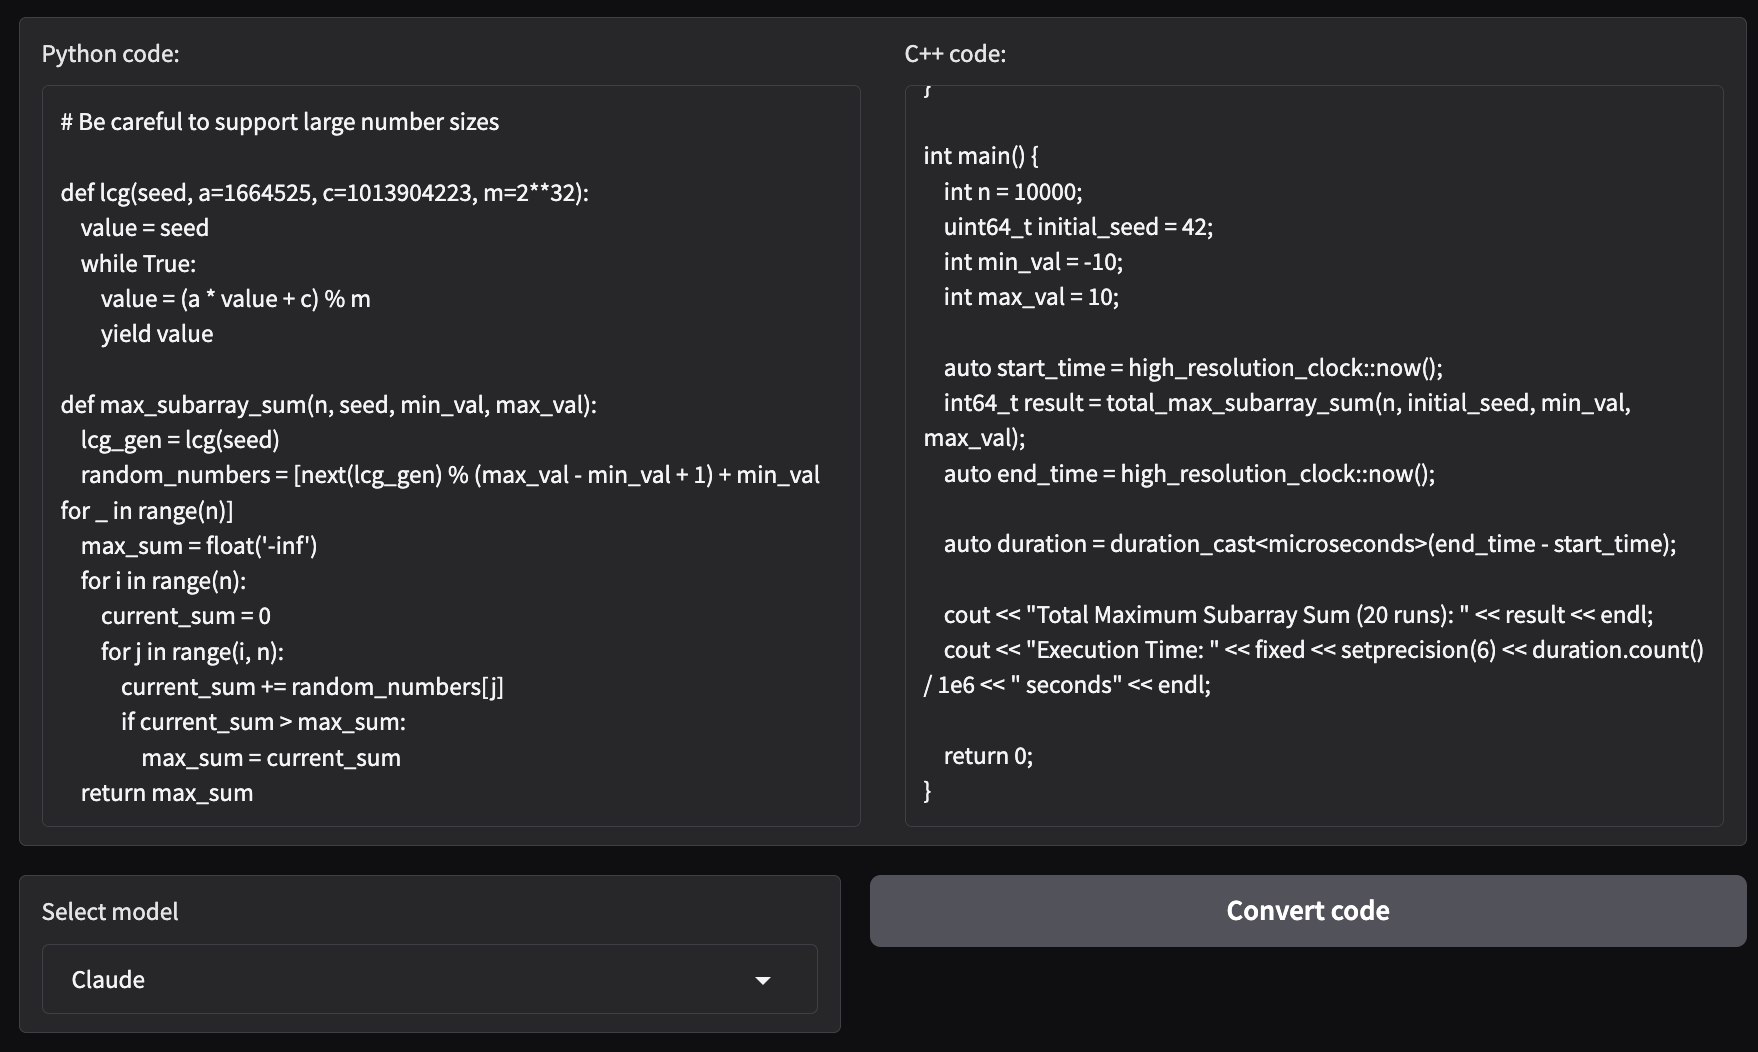

# Gradio UI 2 - code conversion and runtime

In [30]:
def execute_python(code):
    try:
        output = io.StringIO()           # Create a buffer to capture stdout
        sys.stdout = output              # Redirect all print() output to the buffer
        exec(code)                       # Dynamically run the provided Python code
    finally:
        sys.stdout = sys.__stdout__      # Restore original stdout even if an error occurs
    return output.getvalue()             # Return the captured output as a string


In [31]:
import subprocess

def execute_cpp(code):
    # Step 1: Write the C++ code to a file
    with open("optimized.cpp", "w") as f:
        f.write(code)
    
    try:
        # Step 2: Compile the code
        compile_cmd = ["clang++", "-O3", "-std=c++17", "-march=native", "-o", "optimized", "optimized.cpp"]
        compile_result = subprocess.run(compile_cmd, check=True, capture_output=True, text=True)
        
        # Step 3: Run the compiled executable
        run_cmd = ["./optimized"]
        run_result = subprocess.run(run_cmd, check=True, capture_output=True, text=True)
        
        # Step 4: Return the output
        return run_result.stdout
    
    except subprocess.CalledProcessError as e:
        # Return any errors from compilation or execution
        return f"An error occurred:\n{e.stderr or e.stdout or str(e)}"


In [ ]:
# def execute_cpp(code):
#     write_output(code)
#     compiler_cmd = ["clang++", "-O3", "-std=c++17", "-march=armv8.3-a", "-o", "optimized", "optimized.cpp"]
#     try:
#         compile_result = subprocess.run(compiler_cmd, check=True, text=True, capture_output=True)
#         run_cmd = ["./optimized"]
#         run_result = subprocess.run(run_cmd, check=True, text=True, capture_output=True)
#         return run_result.stdout
#     except subprocess.CalledProcessError as e:
#         return f"An error occurred:\n{e.stderr}"

In [32]:
css = """
.python {background-color: #306998;}
.cpp {background-color: #050;}
"""

In [33]:
with gr.Blocks(css=css) as ui:
    gr.Markdown("## Convert code from Python to C++")
    with gr.Row():
        python = gr.Textbox(label="Python code:", value=python_hard, lines=10)
        cpp = gr.Textbox(label="C++ code:", lines=10)
    with gr.Row():
        model = gr.Dropdown(["GPT", "Claude"], label="Select model", value="GPT")
    with gr.Row():
        convert = gr.Button("Convert code")
    with gr.Row():
        python_run = gr.Button("Run Python")
        cpp_run = gr.Button("Run C++")
    with gr.Row():
        python_out = gr.TextArea(label="Python result:", elem_classes=["python"])
        cpp_out = gr.TextArea(label="C++ result:", elem_classes=["cpp"])

    convert.click(optimize, inputs=[python, model], outputs=[cpp])
    python_run.click(execute_python, inputs=[python], outputs=[python_out])
    cpp_run.click(execute_cpp, inputs=[cpp], outputs=[cpp_out])

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


## GPT:
* sometime takes multiple c++ code generation, to have a successful c++ run

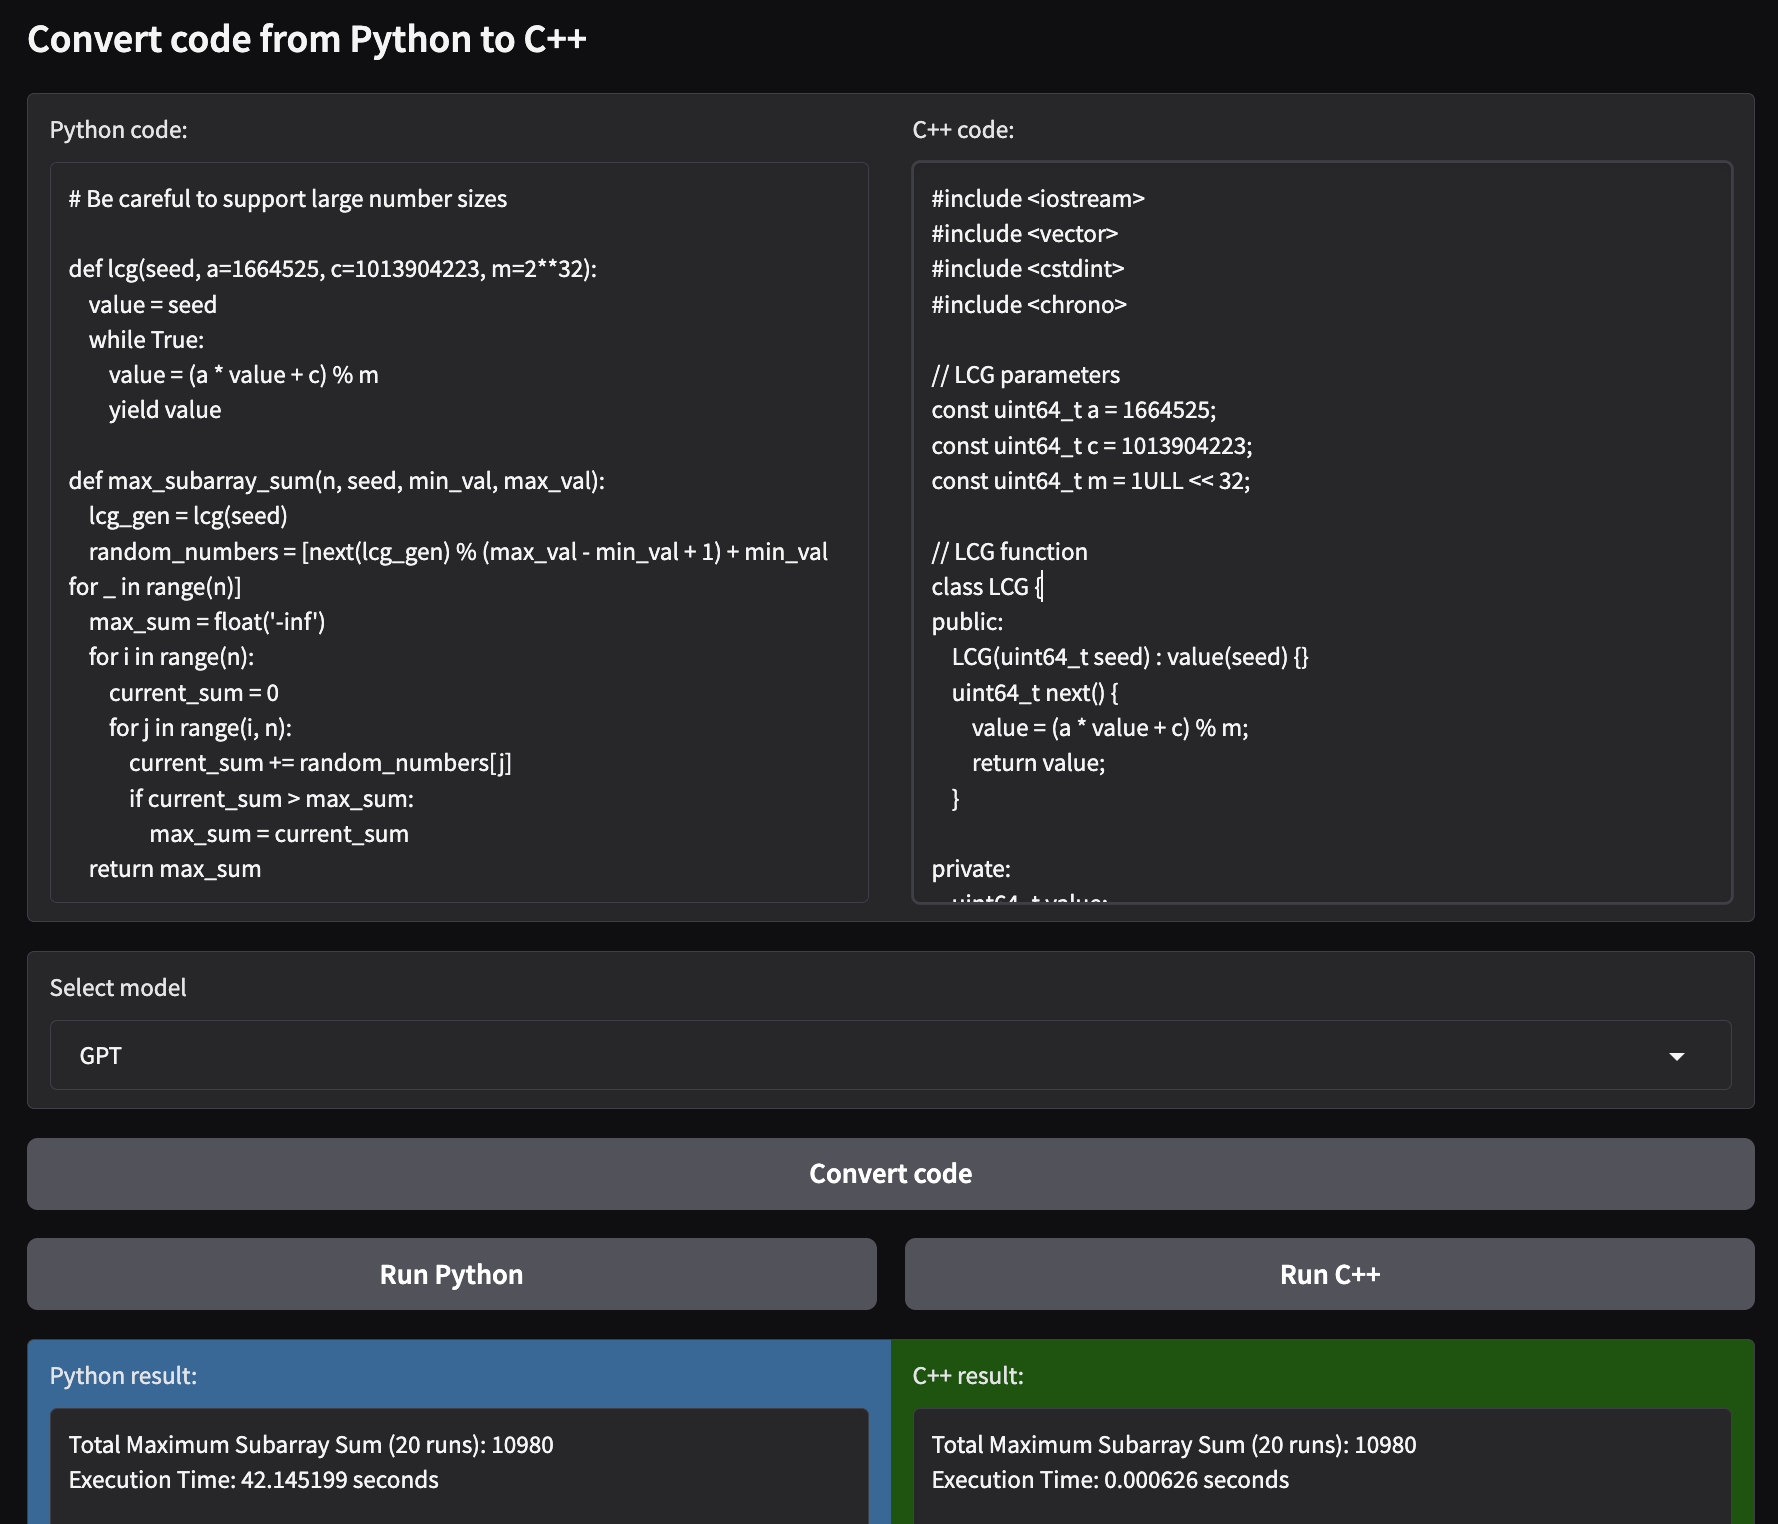



# Cloude

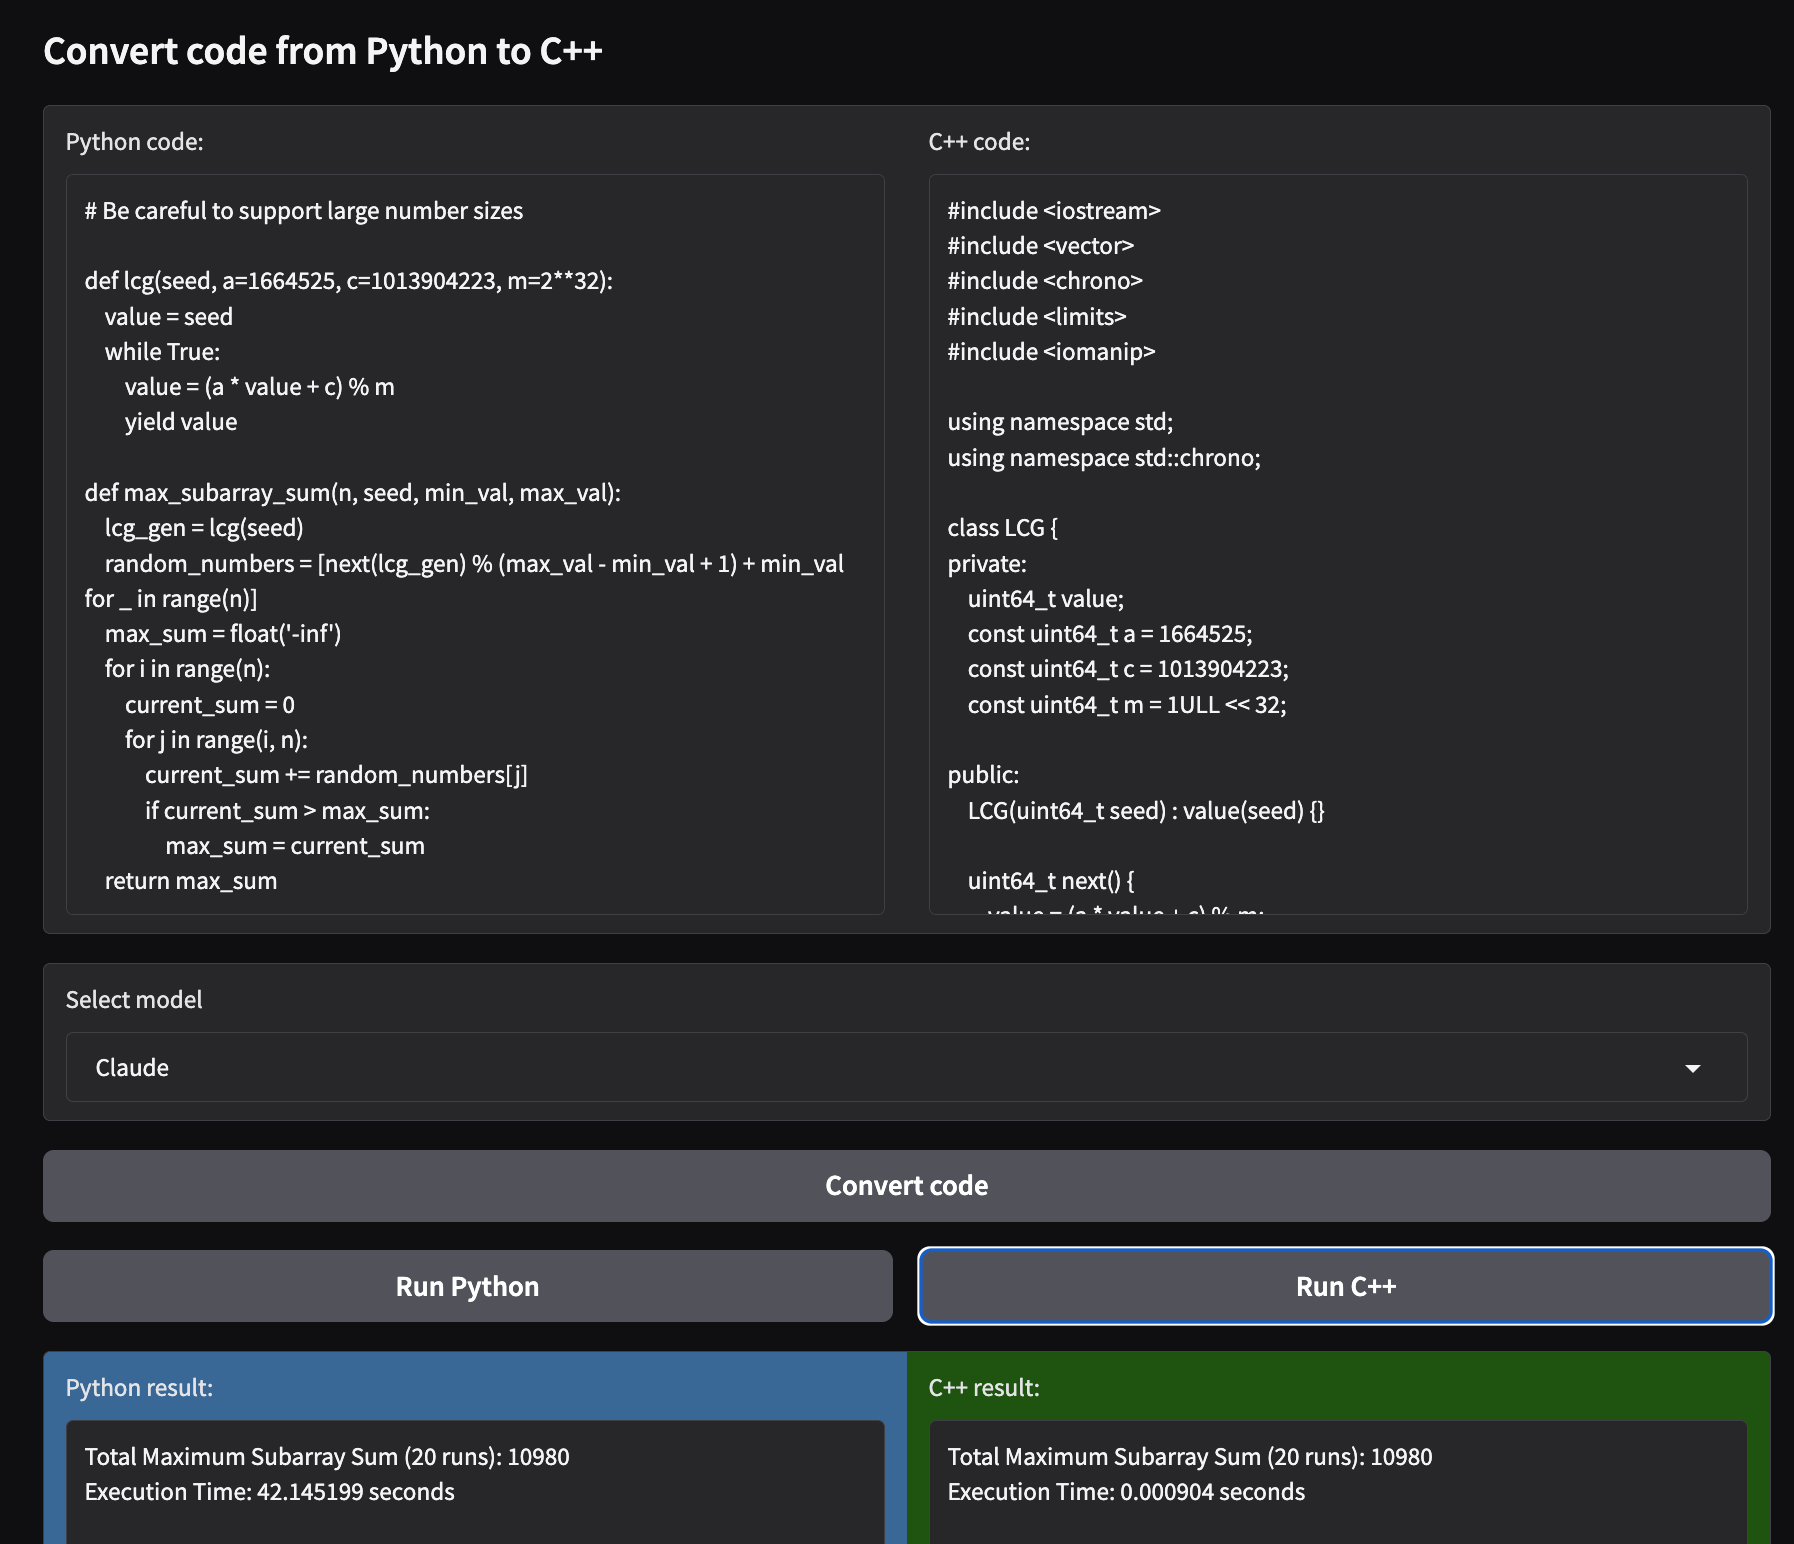

# New section

In [17]:
from huggingface_hub import login, InferenceClient
from transformers import AutoTokenizer

In [ ]:
hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

In [ ]:
code_qwen = "Qwen/CodeQwen1.5-7B-Chat"
code_gemma = "google/codegemma-7b-it"
# URL of endpoints
CODE_QWEN_URL = "https://h1vdol7jxhje3mpn.us-east-1.aws.endpoints.huggingface.cloud"
CODE_GEMMA_URL = "https://c5hggiyqachmgnqg.us-east-1.aws.endpoints.huggingface.cloud"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(code_qwen)
messages = messages_for(pi)
text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

In [ ]:
print(text)

### using the InferenceClient from Hugging Face's text generation inference API, likely to stream output from a model like CodeQwen (Alibaba’s code model)

* Connect to the inference Server
* Initializes a client to interact with a model served at CODE_QWEN_URL.
* hf_token is your Hugging Face API token (for access).


* text: The input prompt (likely Python, C++, or general instruction).

* stream=True: Enables streaming output — you receive chunks as they're generated.

* details=True: Returns rich objects, not just strings.

* max_new_tokens=3000: Limit on how many tokens the model is allowed to generate.

* Iterates over the streaming response.

* r.token.text gives you the text of the current token.

* end="" ensures the output appears fluidly in the terminal.

## Client: 

* InferenceClient is a class provided by Hugging Face's text generation inference library.

client is an instance of that class, which:

* Knows how to connect to a specific model endpoint (e.g. CODE_QWEN_URL)

* Uses your API token to authenticate (hf_token)

* Has methods like .text_generation(...) that let you talk to that model

In [ ]:
client = InferenceClient(CODE_QWEN_URL, token=hf_token)
stream = client.text_generation(
    text, 
    stream=True, 
    details=True, 
    max_new_tokens=3000
)
for r in stream:
    print(r.token.text, end = "")

* In programming—especially when working with APIs or services—a client is an object or module that lets your code communicate with a server or external service. Think of it like a messenger: you give it a request, it sends that to the server, and brings the response back to you.

✅ What You Get from the above cell:
* Live generation, token-by-token, printed to the screen — useful for:

* Interactive code generation

* Building your own chatbot or code assistant

* Streaming into a UI

# Wrap with gradio UI

In [ ]:
def stream_code_qwen(python):
    tokenizer = AutoTokenizer.from_pretrained(code_qwen)
    messages = messages_for(python)
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    client = InferenceClient(CODE_QWEN_URL, token=hf_token)
    stream = client.text_generation(text, stream=True, details=True, max_new_tokens=3000)
    result = ""
    for r in stream:
        result += r.token.text
        yield result    

In [ ]:
def optimize(python, model):
    if model=="GPT":
        result = stream_gpt(python)
    elif model=="Claude":
        result = stream_claude(python)
    elif model=="CodeQwen":
        result = stream_code_qwen(python)
    else:
        raise ValueError("Unknown model")
    for stream_so_far in result:
        yield stream_so_far    

<table style="margin: 0; text-align: left;">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../thankyou.jpg" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#090;">Thank you to @CloudLlama for an amazing contribution</h2>
            <span style="color:#090;">
                A student has contributed a chunk of code to improve this, in the next 2 cells. You can now select which Python porgram to run,
                and a compiler is automatically selected that will work on PC, Windows and Mac. Massive thank you @CloudLlama!
            </span>
        </td>
    </tr>
</table>

In [ ]:
def select_sample_program(sample_program):
    if sample_program=="pi":
        return pi
    elif sample_program=="python_hard":
        return python_hard
    else:
        return "Type your Python program here"

In [ ]:
import platform

VISUAL_STUDIO_2022_TOOLS = "C:\\Program Files\\Microsoft Visual Studio\\2022\\Community\\Common7\Tools\\VsDevCmd.bat"
VISUAL_STUDIO_2019_TOOLS = "C:\\Program Files (x86)\\Microsoft Visual Studio\\2019\\BuildTools\\Common7\\Tools\\VsDevCmd.bat"

simple_cpp = """
#include <iostream>

int main() {
    std::cout << "Hello";
    return 0;
}
"""

def run_cmd(command_to_run):
    try:
        run_result = subprocess.run(command_to_run, check=True, text=True, capture_output=True)
        return run_result.stdout if run_result.stdout else "SUCCESS"
    except:
        return ""

def c_compiler_cmd(filename_base):
    my_platform = platform.system()
    my_compiler = []

    try:
        with open("simple.cpp", "w") as f:
            f.write(simple_cpp)
            
        if my_platform == "Windows":
            if os.path.isfile(VISUAL_STUDIO_2022_TOOLS):
                if os.path.isfile("./simple.exe"):
                    os.remove("./simple.exe")
                compile_cmd = ["cmd", "/c", VISUAL_STUDIO_2022_TOOLS, "&", "cl", "simple.cpp"]
                if run_cmd(compile_cmd):
                    if run_cmd(["./simple.exe"]) == "Hello":
                        my_compiler = ["Windows", "Visual Studio 2022", ["cmd", "/c", VISUAL_STUDIO_2022_TOOLS, "&", "cl", f"{filename_base}.cpp"]]
        
            if not my_compiler:
                if os.path.isfile(VISUAL_STUDIO_2019_TOOLS):
                    if os.path.isfile("./simple.exe"):
                        os.remove("./simple.exe")
                    compile_cmd = ["cmd", "/c", VISUAL_STUDIO_2019_TOOLS, "&", "cl", "simple.cpp"]
                    if run_cmd(compile_cmd):
                        if run_cmd(["./simple.exe"]) == "Hello":
                            my_compiler = ["Windows", "Visual Studio 2019", ["cmd", "/c", VISUAL_STUDIO_2019_TOOLS, "&", "cl", f"{filename_base}.cpp"]]
    
            if not my_compiler:
                my_compiler=[my_platform, "Unavailable", []]
                
        elif my_platform == "Linux":
            if os.path.isfile("./simple"):
                os.remove("./simple")
            compile_cmd = ["g++", "simple.cpp", "-o", "simple"]
            if run_cmd(compile_cmd):
                if run_cmd(["./simple"]) == "Hello":
                    my_compiler = ["Linux", "GCC (g++)", ["g++", f"{filename_base}.cpp", "-o", f"{filename_base}" ]]
    
            if not my_compiler:
                if os.path.isfile("./simple"):
                    os.remove("./simple")
                compile_cmd = ["clang++", "simple.cpp", "-o", "simple"]
                if run_cmd(compile_cmd):
                    if run_cmd(["./simple"]) == "Hello":
                        my_compiler = ["Linux", "Clang++", ["clang++", f"{filename_base}.cpp", "-o", f"{filename_base}"]]
        
            if not my_compiler:
                my_compiler=[my_platform, "Unavailable", []]
    
        elif my_platform == "Darwin":
            if os.path.isfile("./simple"):
                os.remove("./simple")
            compile_cmd = ["clang++", "-Ofast", "-std=c++17", "-march=armv8.5-a", "-mtune=apple-m1", "-mcpu=apple-m1", "-o", "simple", "simple.cpp"]
            if run_cmd(compile_cmd):
                if run_cmd(["./simple"]) == "Hello":
                    my_compiler = ["Macintosh", "Clang++", ["clang++", "-Ofast", "-std=c++17", "-march=armv8.5-a", "-mtune=apple-m1", "-mcpu=apple-m1", "-o", f"{filename_base}", f"{filename_base}.cpp"]]
    
            if not my_compiler:
                my_compiler=[my_platform, "Unavailable", []]
    except:
        my_compiler=[my_platform, "Unavailable", []]
        
    if my_compiler:
        return my_compiler
    else:
        return ["Unknown", "Unavailable", []]


In [ ]:
compiler_cmd = c_compiler_cmd("optimized")

with gr.Blocks(css=css) as ui:
    gr.Markdown("## Convert code from Python to C++")
    with gr.Row():
        python = gr.Textbox(label="Python code:", value=python_hard, lines=10)
        cpp = gr.Textbox(label="C++ code:", lines=10)
    with gr.Row():
        with gr.Column():
            sample_program = gr.Radio(["pi", "python_hard"], label="Sample program", value="python_hard")
            model = gr.Dropdown(["GPT", "Claude", "CodeQwen"], label="Select model", value="GPT")
        with gr.Column():
            architecture = gr.Radio([compiler_cmd[0]], label="Architecture", interactive=False, value=compiler_cmd[0])
            compiler = gr.Radio([compiler_cmd[1]], label="Compiler", interactive=False, value=compiler_cmd[1])
    with gr.Row():
        convert = gr.Button("Convert code")
    with gr.Row():
        python_run = gr.Button("Run Python")
        if not compiler_cmd[1] == "Unavailable":
            cpp_run = gr.Button("Run C++")
        else:
            cpp_run = gr.Button("No compiler to run C++", interactive=False)
    with gr.Row():
        python_out = gr.TextArea(label="Python result:", elem_classes=["python"])
        cpp_out = gr.TextArea(label="C++ result:", elem_classes=["cpp"])

    sample_program.change(select_sample_program, inputs=[sample_program], outputs=[python])
    convert.click(optimize, inputs=[python, model], outputs=[cpp])
    python_run.click(execute_python, inputs=[python], outputs=[python_out])
    cpp_run.click(execute_cpp, inputs=[cpp], outputs=[cpp_out])

ui.launch(inbrowser=True)